In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# ---------- Helper Functions: box uncertainty set & weighting factor ----------

# 1. Construct the box-shaped uncertainty set Ξ (axis-aligned hyper-rectangle)
def build_box_uncertainty(Z_all, qmin=0.01, qmax=0.99, eta=0.02):
    """return [ell, upp] in each dimension of Z_all"""
    low  = np.quantile(Z_all, qmin, axis=0)
    high = np.quantile(Z_all, qmax, axis=0)
    span = high - low
    ell  = low  - eta * span
    upp  = high + eta * span
    # Avoid zero-width intervals
    upp = np.maximum(upp, ell + 1e-10)
    return ell, upp

def build_box_conic_from_bounds(ell, upp, n):
    """
    Rewrite the box uncertainty set  Ξ = { (x,y): ell <= (x,y) <= upp }
    into the form C1 x + c2 y <= d   (C is the nonnegative orthant cone), for direct use of Corollary 3.3.
    Return C1 (m*n), c2 (m,), d (m,), where m = 2*(n+1)
    where n = dim(x), y is a scalar
    """
    m = 2*(n+1)
    C1 = np.zeros((m, n))
    c2 = np.zeros(m)
    d  = np.zeros(m)

    row = 0
    # upper bound： x_j <= upp_j
    for j in range(n):
        C1[row, j] = 1.0
        d[row] = upp[j]
        row += 1
    # lower bound： -x_j <= -ell_j
    for j in range(n):
        C1[row, j] = -1.0
        d[row] = -ell[j]
        row += 1
    # upper bound for y： y <= upp_y
    c2[row] = 1.0
    d[row] = upp[n]
    row += 1
    # lower bound for y： -y <= -ell_y
    c2[row] = -1.0
    d[row] = -ell[n]
    row += 1

    assert row == m
    return C1, c2, d

# 2a. Compute time-dependent sample weights (exponential forgetting)
def time_weights_from_indices(time_idx, now_t, decay):
    raw = decay ** (now_t - time_idx)
    pi = raw / raw.sum()
    return pi

# 2b. Optimal weights according to Proposition 2 (for p = 1)
def optimal_weights_prop2(T, eps_over_rho):
    """
    Proposition 2 optimal weights for p = 1:
    - T = history length
    - eps_over_rho = ε/ρ in the paper, where eps in our code is ambuiguity radius, rho is the wasserstein distance between Pt and Pt+1
    Return weights w of length T
    """

    # s = floor(eps / rho)
    s = int(np.floor(eps_over_rho))
    s = max(1, min(s, T))  # truncate to [1, T]
    
    w = np.zeros(T)
    denom = s * (2 * eps_over_rho - s - 1)
    
    for t in range(T - s, T):
        # t runs from T-s to T-1  (0-index)
        w[t] = 2 * ((eps_over_rho) + (t+1) - T - 1) / denom

    return w

# 3. DRO ε-insensitive SVR
# ---------- Core：DRO-SVR following Corollary 3.3 ----------
def solve_dro_svr_cor33(X, y, C1, c2, d, pi, epsilon=1.0, rho=0.5, use_mosek=True):
    """
    Corollary 3.3 (Support Vector Regression):
      min   λ ρ + sum_i π_i s_i
      s.t.  y_i - <w,x_i> - ε + <p_i^+, d - C1 x_i - c2 y_i> <= s_i
            <w,x_i> - y_i - ε + <p_i^-, d - C1 x_i - c2 y_i> <= s_i
            || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_* <= λ
            || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_* <= λ
            p_i^+, p_i^- >= 0,  s_i >= 0
    """
    N, n = X.shape
    m = C1.shape[0]  # number of constraints (2*(n+1))

    w   = cp.Variable(n)
    lam = cp.Variable(nonneg=True)
    s   = cp.Variable(N, nonneg=True)

    constraints = []

    # pre-calculate (d - C1 x_i - c2 y_i) for each sample
    D_minus_Axi_cy = (d[None, :] - X @ C1.T - np.outer(y, c2))  # (N,m)

    for i in range(N):
        p_plus_i  = cp.Variable(m, nonneg=True)
        p_minus_i = cp.Variable(m, nonneg=True)

        # y_i - <w,x_i> - ε + <p_i^+, ...> <= s_i
        lhs1_i = (y[i] - X[i] @ w - epsilon + p_plus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs1_i <= s[i]]

        # <w,x_i> - y_i - ε + <p_i^-, ...> <= s_i
        lhs2_i = (X[i] @ w - y[i] - epsilon + p_minus_i @ D_minus_Axi_cy[i, :])
        constraints += [lhs2_i <= s[i]]

        # || ( C1^T p_i^+ + w ,  c2^T p_i^+ - 1 ) ||_2 <= λ
        # || ( C1^T p_i^- - w ,  c2^T p_i^- + 1 ) ||_2 <= λ
        vec_minus = cp.hstack([C1.T @ p_minus_i - w,  c2 @ p_minus_i + 1.0])
        vec_plus = cp.hstack([C1.T @ p_plus_i + w,  c2 @ p_plus_i - 1.0])

        constraints += [
            cp.norm(vec_plus,  'inf') <= lam,
            cp.norm(vec_minus, 'inf') <= lam
        ]

    # objective：λ ρ + sum_i π_i s_i
    pi_param = cp.Parameter(N, nonneg=True, value=np.asarray(pi, float))
    obj = cp.Minimize(lam * rho + pi_param @ s)

    prob = cp.Problem(obj, constraints)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)

    return w.value, prob.status

# 4. Empirical ε-insensitive SVR (no regularization, time-weighted)
def solve_empirical_svr_noreg(X, y, epsilon=1.0, sample_weights=None, use_mosek=True):
    N, n = X.shape
    w = cp.Variable(n)
    resid = y - X @ w
    loss  = cp.pos(cp.abs(resid) - epsilon)  # max(0, |r|-ε)

    if sample_weights is None:
        obj = cp.Minimize(cp.sum(loss) / N)
    else:
        sw = cp.Parameter(N, nonneg=True, value=np.asarray(sample_weights, float))
        weighted_loss = cp.sum(cp.multiply(sw, loss))
        obj = cp.Minimize(weighted_loss)

    prob = cp.Problem(obj)
    try:
        prob.solve(solver=cp.MOSEK if use_mosek else cp.ECOS, verbose=False)
    except cp.SolverError:
        prob.solve(solver=cp.ECOS, verbose=False)
    return w.value, prob.status

# 5. ε-insensitive loss
def eps_ins_loss(y_true, y_pred, eps):
    return np.maximum(0, np.abs(y_true - y_pred) - eps)

In [3]:
def load_real_excel_dataset(path):
    df = pd.read_excel(path)

    if 'No' in df.columns:
        df = df.drop(columns=['No'])

    data = df.values
    X = data[:, :-1].astype(float)
    y = data[:, -1].astype(float)

    X1 = X[:, 0]
    year = np.floor(X1).astype(int)
    month_float = np.round((X1 - year) * 12).astype(int)
    month = np.clip(month_float, 1, 12)

    year_min = year.min()
    time_index = (year - year_min) * 12 + (month - 1)

    X[:, 0] = time_index

    y_m2 = y / 3.3

    return X, y_m2, time_index

X_raw, y_real, time_index_all = load_real_excel_dataset("Real estate valuation data set.xlsx")

两个方法来说我们修改数据的目的，一个是我们假设这种情况可以发生，另一个是假设我们现在存在adversary对手，要修改我们的数据，我们需要我们的数据保持robustness
可以提及optimal weights确实比我们选的exponential weights更好，因为paper里他用的experiment太简单了，我们用我们的更复杂的真实的data来test他的optimal确实optimal。
adversary training report citing


=== Time ratio 0.5 | step drift: train=1.5, test=3.0 ===
Train+Val samples: 200
Test samples     : 214
  Train samples: 160
  Val   samples: 40
  [SAA]   val eps-loss: 1.3279343844768556
  [W-SAA] best val eps-loss: 1.2030899971302274 | best decay = 0.65
  [WDRO]  best val eps-loss: 1.2997541955983916 | best decay = 0.65 | best rho = 0.0001
  [Prop2] best val eps-loss: 1.0659816092366026 | best rho = 0.0001 | best eps/rho = 2.66
>> [SAA]   test eps-loss: 5.303960436752351
>> [W-SAA] test eps-loss: 5.25114042355116
>> [WDRO]  test eps-loss: 5.303852355536951
>> [Prop2] test eps-loss: 4.7368281685410905

=== Time ratio 0.6 | step drift: train=1.5, test=3.0 ===
Train+Val samples: 225
Test samples     : 189
  Train samples: 180
  Val   samples: 45
  [SAA]   val eps-loss: 1.0188784735284695
  [W-SAA] best val eps-loss: 0.9757207093445034 | best decay = 0.65
  [WDRO]  best val eps-loss: 1.0105773895404313 | best decay = 0.65 | best rho = 0.0001
  [Prop2] best val eps-loss: 0.958629547410300

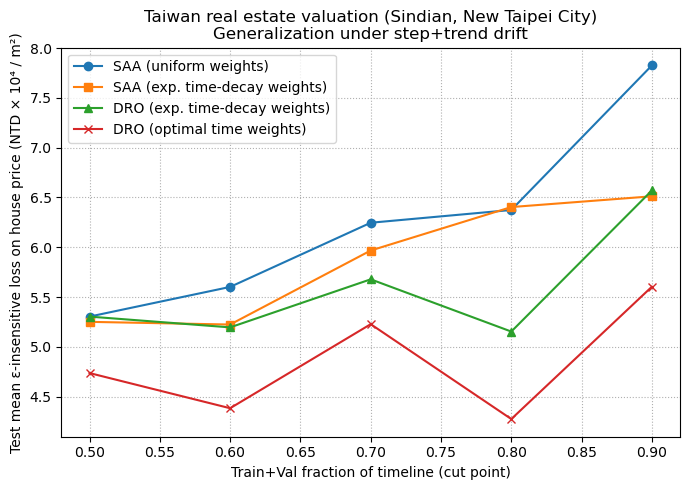

In [4]:
# ----- base labels (no drift) -----
y_base = y_real.copy()   # <-- make sure y_real here is the ORIGINAL real label (no drift)

# ----- global normalization stats (fixed, to avoid leakage/extra shifts) -----
y_mean = y_base.mean()
y_std  = y_base.std()

xj = X_raw[:, 2]         # feature_id = 2 (same as you used)
xj_mean = xj.mean()
xj_std  = xj.std()

# sort once (keep your original ordering logic)
order = np.argsort(time_index_all)
time_sorted = time_index_all[order]
X_sorted_full = X_raw[order]
y_base_sorted = y_base[order]

# your feature matrix (same as before)
X_features_sorted = X_sorted_full[:, 1:]

all_times = np.unique(time_sorted.astype(int))
T_total = len(all_times)

# ================================
# 0. Hyperparameter grid
# ================================
epsilon = 1
time_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
rho_list    = np.logspace(-4, 1, num=10)
decay_list  = [0.65, 0.75, 0.85, 0.95]

results = {
    "ratio": [],
    "SAA": [],
    "W-SAA": [],
    "WDRO": [],
    "Prop2": []
}

# ================================
# Main loop over training ratios
# ================================
for ratio in time_ratios:

    # ------------------------------------------------
    # 1. Outer split: Train+Val / Test by MONTH
    # ------------------------------------------------
    T_cut = int(ratio * T_total)

    trainval_times = all_times[:T_cut]
    test_times     = all_times[T_cut:]

    trainval_mask = np.isin(time_sorted.astype(int), trainval_times)
    test_mask     = np.isin(time_sorted.astype(int), test_times)

    # ------------------------------------------------
    # 1.5 Inject STEP correlation drift AFTER split
    # ------------------------------------------------
    strength_train = 1.5
    strength_test  = 3.0
    feature_id = 2

    # fixed stats (already computed above, but make them numerically safe)
    y_std_safe  = y_std  + 1e-12
    xj_std_safe = xj_std + 1e-12

    # normalized time on the FULL horizon (sorted order)
    t_sorted = (time_sorted - time_sorted.min()) / (time_sorted.max() - time_sorted.min() + 1e-12)

    # normalize y and x_j using FIXED global stats
    y_norm_sorted = (y_base_sorted - y_mean) / y_std_safe

    xj_sorted = X_sorted_full[:, feature_id]
    xj_norm_sorted = (xj_sorted - xj_mean) / xj_std_safe

    # step strength: trainval uses one slope, test uses another (bigger) slope
    strength_vec = np.zeros_like(t_sorted, dtype=float)
    strength_vec[trainval_mask] = strength_train
    strength_vec[test_mask]     = strength_test

    # apply drift: (strength * t) * xj_norm  (THIS matches your original design)
    y_sorted = (y_norm_sorted + (strength_vec * t_sorted) * xj_norm_sorted) * y_std_safe + y_mean

    # now create train/val/test splits using drifted y_sorted
    X_trainval = X_features_sorted[trainval_mask]
    y_trainval = y_sorted[trainval_mask]

    X_test = X_features_sorted[test_mask]
    y_test = y_sorted[test_mask]

    print(f"\n=== Time ratio {ratio:.1f} | step drift: train={strength_train}, test={strength_test} ===")
    print("Train+Val samples:", X_trainval.shape[0])
    print("Test samples     :", X_test.shape[0])

    # ------------------------------------------------
    # 2. Inner split: Train / Val  (NO test leakage)
    # ------------------------------------------------
    inner_ratio = 0.8
    n_train = int(inner_ratio * X_trainval.shape[0])

    X_train = X_trainval[:n_train]
    y_train = y_trainval[:n_train]

    X_val = X_trainval[n_train:]
    y_val = y_trainval[n_train:]

    print("  Train samples:", X_train.shape[0])
    print("  Val   samples:", X_val.shape[0])

    # ------------------------------------------------
    # 3. Build MONTH → SAMPLE index ONLY on TRAIN
    # ------------------------------------------------
    time_train = time_sorted[trainval_mask][:n_train].astype(int)

    unique_times, inv_idx = np.unique(time_train, return_inverse=True)
    T_time = len(unique_times)
    counts = np.bincount(inv_idx)   # samples per month

    # ------------------------------------------------
    # 4. Build Box uncertainty set (TRAIN only)
    # ------------------------------------------------
    Z_train = np.hstack([X_train, y_train[:, None]])
    ell, upp = build_box_uncertainty(Z_train, qmin=0.01, qmax=0.99, eta=0.02)
    C1, c2, d = build_box_conic_from_bounds(ell, upp, X_train.shape[1])

    # ============================================================
    # 5. SAA  (no hyperparameter tuning)
    # ============================================================
    w_saa, _ = solve_empirical_svr_noreg(X_train, y_train, epsilon=epsilon)
    y_val_pred = X_val @ w_saa
    val_loss_saa = eps_ins_loss(y_val, y_val_pred, epsilon).mean()
    print("  [SAA]   val eps-loss:", val_loss_saa)

    # ============================================================
    # 6. W-SAA  (tune decay on VAL)
    # ============================================================
    best_wsaa_loss = np.inf
    best_wsaa_decay = None

    for decay in decay_list:
        time_idx_month = np.arange(T_time)

        pi_time_wsaa = time_weights_from_indices(
            time_idx_month,
            now_t=T_time - 1,
            decay=decay
        )

        pi_wsaa_samples = pi_time_wsaa[inv_idx] / counts[inv_idx]
        pi_wsaa_samples = pi_wsaa_samples / pi_wsaa_samples.sum()

        w_wsaa, _ = solve_empirical_svr_noreg(
            X_train, y_train,
            epsilon=epsilon,
            sample_weights=pi_wsaa_samples
        )

        y_val_pred = X_val @ w_wsaa
        val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

        if val_loss < best_wsaa_loss:
            best_wsaa_loss = val_loss
            best_wsaa_decay = decay

    print("  [W-SAA] best val eps-loss:", best_wsaa_loss,
          "| best decay =", best_wsaa_decay)

    # ============================================================
    # 7. WDRO  (tune decay + rho on VAL)
    # ============================================================
    best_wdro_loss = np.inf
    best_wdro_decay = None
    best_wdro_rho = None

    for decay in decay_list:
        time_idx_month = np.arange(T_time)

        pi_time_wdro = time_weights_from_indices(
            time_idx_month,
            now_t=T_time - 1,
            decay=decay
        )

        pi_wdro_samples = pi_time_wdro[inv_idx] / counts[inv_idx]
        pi_wdro_samples = pi_wdro_samples / pi_wdro_samples.sum()

        for rho in rho_list:
            w_wdro, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_wdro_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_val_pred = X_val @ w_wdro
            val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

            if val_loss < best_wdro_loss:
                best_wdro_loss = val_loss
                best_wdro_decay = decay
                best_wdro_rho = rho

    print("  [WDRO]  best val eps-loss:", best_wdro_loss,
          "| best decay =", best_wdro_decay,
          "| best rho =", best_wdro_rho)

    # ============================================================
    # 8. Prop2-DRO  (tune rho + eps/rho on VAL)
    # ============================================================
    eps_over_rho_list = np.linspace(1.1, T_time, 6)

    best_prop2_loss = np.inf
    best_prop2_rho = None
    best_prop2_epsrho = None

    for rho in rho_list:
        for eps_over_rho in eps_over_rho_list:

            pi_time_prop2 = optimal_weights_prop2(T_time, eps_over_rho)
            pi_time_prop2 = pi_time_prop2 / pi_time_prop2.sum()

            pi_prop2_samples = pi_time_prop2[inv_idx] / counts[inv_idx]
            pi_prop2_samples = pi_prop2_samples / pi_prop2_samples.sum()

            w_prop2, _ = solve_dro_svr_cor33(
                X_train, y_train,
                C1, c2, d,
                pi_prop2_samples,
                epsilon=epsilon,
                rho=rho
            )

            y_val_pred = X_val @ w_prop2
            val_loss = eps_ins_loss(y_val, y_val_pred, epsilon).mean()

            if val_loss < best_prop2_loss:
                best_prop2_loss = val_loss
                best_prop2_rho = rho
                best_prop2_epsrho = eps_over_rho

    print("  [Prop2] best val eps-loss:", best_prop2_loss,
          "| best rho =", best_prop2_rho,
          "| best eps/rho =", best_prop2_epsrho)

    # ============================================================
    # 9. Final retraining on Train+Val → TEST evaluation
    # ============================================================

    # ---------- SAA ----------
    w_saa_final, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval, epsilon=epsilon
    )
    test_loss_saa = eps_ins_loss(
        y_test, X_test @ w_saa_final, epsilon
    ).mean()

    # ---------- W-SAA ----------
    time_idx_month_tv = np.arange(len(np.unique(time_sorted[trainval_mask].astype(int))))
    pi_time_wsaa_tv = time_weights_from_indices(
        time_idx_month_tv,
        now_t=len(time_idx_month_tv) - 1,
        decay=best_wsaa_decay
    )

    time_trainval = time_sorted[trainval_mask].astype(int)
    unique_tv, inv_idx_tv = np.unique(time_trainval, return_inverse=True)
    counts_tv = np.bincount(inv_idx_tv)

    pi_wsaa_samples_tv = pi_time_wsaa_tv[inv_idx_tv] / counts_tv[inv_idx_tv]
    pi_wsaa_samples_tv = pi_wsaa_samples_tv / pi_wsaa_samples_tv.sum()

    w_wsaa_final, _ = solve_empirical_svr_noreg(
        X_trainval, y_trainval,
        epsilon=epsilon,
        sample_weights=pi_wsaa_samples_tv
    )
    test_loss_wsaa = eps_ins_loss(
        y_test, X_test @ w_wsaa_final, epsilon
    ).mean()

    # ---------- WDRO ----------
    pi_time_wdro_tv = time_weights_from_indices(
        time_idx_month_tv,
        now_t=len(time_idx_month_tv) - 1,
        decay=best_wdro_decay
    )

    pi_wdro_samples_tv = pi_time_wdro_tv[inv_idx_tv] / counts_tv[inv_idx_tv]
    pi_wdro_samples_tv = pi_wdro_samples_tv / pi_wdro_samples_tv.sum()

    w_wdro_final, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1, c2, d,
        pi_wdro_samples_tv,
        epsilon=epsilon,
        rho=best_wdro_rho
    )
    test_loss_wdro = eps_ins_loss(
        y_test, X_test @ w_wdro_final, epsilon
    ).mean()

    # ---------- Prop2 ----------
    pi_time_prop2_tv = optimal_weights_prop2(
        len(time_idx_month_tv),
        best_prop2_epsrho
    )
    pi_time_prop2_tv = pi_time_prop2_tv / pi_time_prop2_tv.sum()

    pi_prop2_samples_tv = pi_time_prop2_tv[inv_idx_tv] / counts_tv[inv_idx_tv]
    pi_prop2_samples_tv = pi_prop2_samples_tv / pi_prop2_samples_tv.sum()

    w_prop2_final, _ = solve_dro_svr_cor33(
        X_trainval, y_trainval,
        C1, c2, d,
        pi_prop2_samples_tv,
        epsilon=epsilon,
        rho=best_prop2_rho
    )
    test_loss_prop2 = eps_ins_loss(
        y_test, X_test @ w_prop2_final, epsilon
    ).mean()

    print(">> [SAA]   test eps-loss:", test_loss_saa)
    print(">> [W-SAA] test eps-loss:", test_loss_wsaa)
    print(">> [WDRO]  test eps-loss:", test_loss_wdro)
    print(">> [Prop2] test eps-loss:", test_loss_prop2)

    results["ratio"].append(ratio)
    results["SAA"].append(test_loss_saa)
    results["W-SAA"].append(test_loss_wsaa)
    results["WDRO"].append(test_loss_wdro)
    results["Prop2"].append(test_loss_prop2)

# ===== plot =====
ratios = np.array(results["ratio"])

plt.figure(figsize=(7, 5))

plt.plot(ratios, results["SAA"],   marker="o", label="SAA (uniform weights)")
plt.plot(ratios, results["W-SAA"], marker="s", label="SAA (exp. time-decay weights)")
plt.plot(ratios, results["WDRO"],  marker="^", label="DRO (exp. time-decay weights)")
plt.plot(ratios, results["Prop2"], marker="x", label="DRO (optimal time weights)")

plt.xlabel("Train+Val fraction of timeline (cut point)")
plt.ylabel("Test mean ε-insensitive loss on house price (NTD × 10⁴ / m²)")
plt.title(
    "Taiwan real estate valuation (Sindian, New Taipei City)\n"
    "Generalization under step+trend drift"
)
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()